# 가위바위보 분류기를 만들자

In [38]:
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


In [29]:
# 사이즈 변경하기
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!


In [30]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock" # 바위 이미지
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper" # 보 이미지
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

100  images to be resized.
100  images resized.
바위 이미지 resize 완료!
100  images to be resized.
100  images resized.
보 이미지 resize 완료!


In [31]:
# 가위, 바위, 보 데이터를 읽을 수 있는 load_data() 함수를 만들어야 한다

def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


라벨:  0


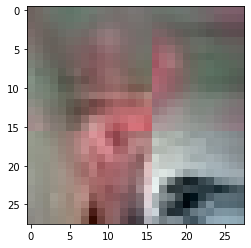

In [32]:
# 이미지 불러와서 확인하자
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

In [33]:
# 딥러닝 네트워크 설계하기
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=10

# model을 직접 만들어 보세요.
# Hint! model의 입력/출력부에 특히 유의해 주세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                25632     
_________________________________________________________________
dense_5 (Dense)              (

In [34]:
# 딥러닝 네트워크 학습시키기

print("Before Reshape - x_train_norm shape: {}".format(x_train_norm.shape))
x_train_reshaped=x_train_norm.reshape( -1, 28, 28, 3)  # 데이터갯수에 -1을 쓰면 reshape시 자동계산됩니다.
print("After Reshape - x_train_reshaped shape: {}".format(x_train_reshaped.shape))


model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_reshaped, y_train, epochs=n_train_epoch)


Before Reshape - x_train_norm shape: (300, 28, 28, 3)
After Reshape - x_train_reshaped shape: (300, 28, 28, 3)
Epoch 1/10
10/10 [==============================] - 0s 3ms/step - loss: 2.0495 - accuracy: 0.2900
Epoch 2/10
10/10 [==============================] - 0s 3ms/step - loss: 1.6992 - accuracy: 0.3333
Epoch 3/10
10/10 [==============================] - 0s 3ms/step - loss: 1.4788 - accuracy: 0.3333
Epoch 4/10
10/10 [==============================] - 0s 3ms/step - loss: 1.2468 - accuracy: 0.3433
Epoch 5/10
10/10 [==============================] - 0s 3ms/step - loss: 1.1171 - accuracy: 0.3600
Epoch 6/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0999 - accuracy: 0.3733
Epoch 7/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0708 - accuracy: 0.4033
Epoch 8/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0723 - accuracy: 0.3867
Epoch 9/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0778 - accuracy: 0.3533
Epoch 1

In [35]:
# 잘만들었는지 테스트하기

# 테스트 가위바위보 이미지 크기 맞추기
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor"
resize_images(image_dir_path)
print("가위 이미지 resize 완료!")

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock"
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper"
resize_images(image_dir_path)
print("보 이미지 resize 완료!")

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

print("Before Reshape - x_test_norm shape: {}".format(x_test_norm.shape))
x_test_reshaped=x_test_norm.reshape( -1, 28, 28, 3)
print("After Reshape - x_test_reshaped shape: {}".format(x_test_reshaped.shape))

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!
100  images to be resized.
100  images resized.
바위 이미지 resize 완료!
100  images to be resized.
100  images resized.
보 이미지 resize 완료!
학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)
Before Reshape - x_test_norm shape: (300, 28, 28, 3)
After Reshape - x_test_reshaped shape: (300, 28, 28, 3)


In [36]:
# 테스트 시키기
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_test_reshaped, y_test, epochs=10)

Epoch 1/10
10/10 [==============================] - 0s 3ms/step - loss: 1.1050 - accuracy: 0.3667
Epoch 2/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0556 - accuracy: 0.4400
Epoch 3/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0357 - accuracy: 0.4633
Epoch 4/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0106 - accuracy: 0.4800
Epoch 5/10
10/10 [==============================] - 0s 3ms/step - loss: 0.9523 - accuracy: 0.6000
Epoch 6/10
10/10 [==============================] - 0s 3ms/step - loss: 0.9080 - accuracy: 0.7233
Epoch 7/10
10/10 [==============================] - 0s 3ms/step - loss: 0.8352 - accuracy: 0.8667
Epoch 8/10
10/10 [==============================] - 0s 3ms/step - loss: 0.7936 - accuracy: 0.6567
Epoch 9/10
10/10 [==============================] - 0s 3ms/step - loss: 0.7309 - accuracy: 0.7633
Epoch 10/10
10/10 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.8633


In [37]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.evaluate()을 사용해 봅시다.

test_loss, test_accuracy = model.evaluate(x_test_reshaped,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 0.5837 - accuracy: 0.9567
test_loss: 0.5837383270263672 
test_accuracy: 0.9566666483879089


In [ ]:
# 회고